# 1. Setup and load data

### 1.1 Install dependencies and setup

In [5]:
! pip install tensorflow opencv-python matplotlib Pillow

UnboundLocalError: cannot access local variable 'child' where it is not associated with a value

In [ ]:
! pip list

KeyboardInterrupt: 

In [6]:
import tensorflow as tf
import os

### 1.2 Remove doggy images

In [7]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

In [8]:
data_dir = '../data'

In [9]:
image_ext = ['jpeg', 'jpg',  'png', 'bmp']

In [10]:
for image_class in [dir for dir in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir,dir))]:
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            pil_img = Image.open(image_path)
            img = np.array(pil_img)
            tip = pil_img.format.lower()
            if tip not in image_ext:
                print(f'The following image has a not allowed format:\n{image_path}')
                os.remove(image_path)
        except Exception as e:
            print(f'Issues with the following image: {image_path}')
            os.remove(image_path)

### 1.3 Load data

In [11]:
data = tf.keras.utils.image_dataset_from_directory('../data') # it creates a generator

Found 304 files belonging to 2 classes.


0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


In [12]:
data_iterator = data.as_numpy_iterator() # allow us to iterate through the data

In [13]:
batch = data_iterator.next() # grab the data

In [14]:
# NOTE
# 0 -> happy people
# 1 -> sad people
batch[1]

array([0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1], dtype=int32)

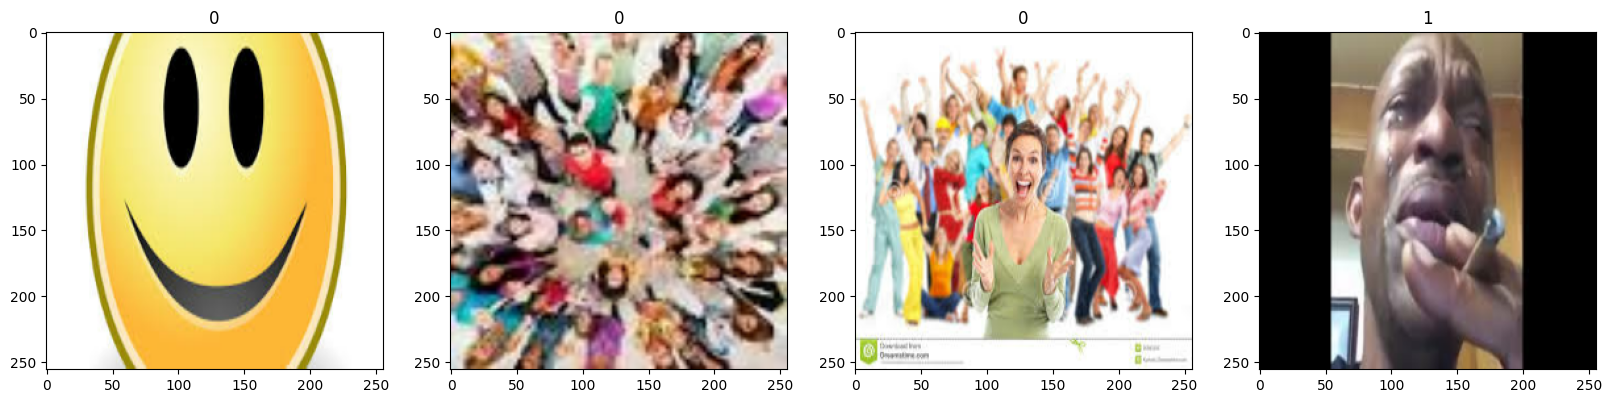

In [15]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## 2. Process data

### 2.1 Scale data

In [16]:
data = data.map(lambda x, y: (x/255, y))

In [17]:
scaled_data_iterator = data.as_numpy_iterator()

In [18]:
scaled_data_iterator.next()

(array([[[[1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          ...,
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00]],
 
         [[1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          ...,
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00]],
 
         [[1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          ...,
          [1.00000000e+00, 1.00000000e+00, 1.0000

### 2.2 Split data in different set (avoid overfitting)

In [19]:
len(data)

10

In [20]:
train_set = int(len(data) * .7)
val_set = int(len(data) * .2)
test_set = int(len(data) * .1)

In [21]:
train_set + val_set + test_set == len(data) # check partition

True

In [22]:
train = data.take(train_set)
val = data.skip(train_set).take(val_set)
test = data.skip(train_set + val_set).take(test_set)
# Check with Notion an alternative to create the different sets

# 3. Deep Model

### 3.1 Build deep learning model

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

In [24]:
model = Sequential()

In [25]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [26]:
#optimizer
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 


 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 14400)             0         
                                                                 
 dense (Dense)               (None, 256)               3686656   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 3696625 (14.10 MB)
Trainable params: 3696625 (14.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 3.2 Train

In [28]:
logs_dir = '../logs'

In [29]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_dir)

In [30]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 17s 2s/step - loss: 0.7490 - accuracy: 0.5089 - val_loss: 0.5759 - val_accuracy: 0.6406
Epoch 2/20
7/7 [==============================] - 17s 2s/step - loss: 0.5775 - accuracy: 0.7455 - val_loss: 0.5857 - val_accuracy: 0.7031
Epoch 3/20
7/7 [==============================] - 14s 2s/step - loss: 0.4500 - accuracy: 0.7991 - val_loss: 0.6024 - val_accuracy: 0.7031
Epoch 4/20
7/7 [==============================] - 13s 1s/step - loss: 0.3730 - accuracy: 0.8795 - val_loss: 0.3001 - val_accuracy: 0.8750
Epoch 5/20
7/7 [==============================] - 13s 1s/step - loss: 0.3095 - accuracy: 0.9062 - val_loss: 0.2402 - val_accuracy: 0.9375
Epoch 6/20
7/7 [==============================] - 15s 2s/step - loss: 0.2077 - accuracy: 0.9241 - val_loss: 0.2780 - val_accuracy: 0.9062
Epoch 7/20
7/7 [==============================] - 16s 2s/step - loss: 0.2054 - accuracy: 0.9241 - val_loss: 0.0956 - val_accuracy: 0.9844
Epoch 8/20
7/7 [==================

In [31]:
hist.history

{'loss': [0.7489608526229858,
  0.5774797797203064,
  0.4499523341655731,
  0.37304067611694336,
  0.3094908595085144,
  0.2076503187417984,
  0.2053901106119156,
  0.11650149524211884,
  0.07256950438022614,
  0.07997006177902222,
  0.05987837538123131,
  0.02957632578909397,
  0.02859795093536377,
  0.015602022409439087,
  0.019748840481042862,
  0.021866455674171448,
  0.027450788766145706,
  0.013537585735321045,
  0.015949338674545288,
  0.011101982556283474],
 'accuracy': [0.5089285969734192,
  0.7455357313156128,
  0.7991071343421936,
  0.8794642686843872,
  0.90625,
  0.9241071343421936,
  0.9241071343421936,
  0.9732142686843872,
  0.9910714030265808,
  0.9642857313156128,
  0.9776785969734192,
  0.9910714030265808,
  0.9910714030265808,
  1.0,
  0.9866071343421936,
  0.9910714030265808,
  0.9910714030265808,
  0.9955357313156128,
  0.9910714030265808,
  0.9955357313156128],
 'val_loss': [0.5759447813034058,
  0.5857326984405518,
  0.6023761034011841,
  0.3001245856285095,
  0

### 3.3 Plot Performance

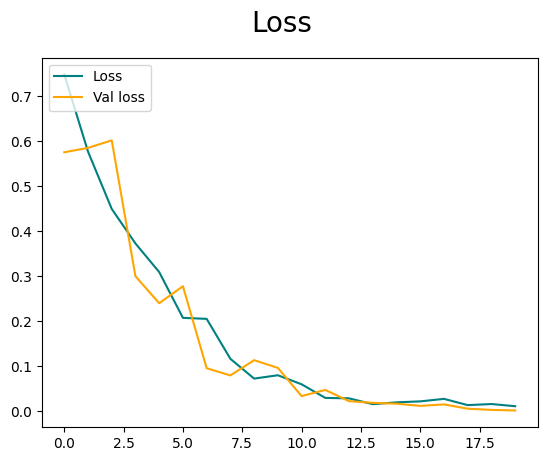

In [32]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='Loss')
plt.plot(hist.history['val_loss'], color='orange', label='Val loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

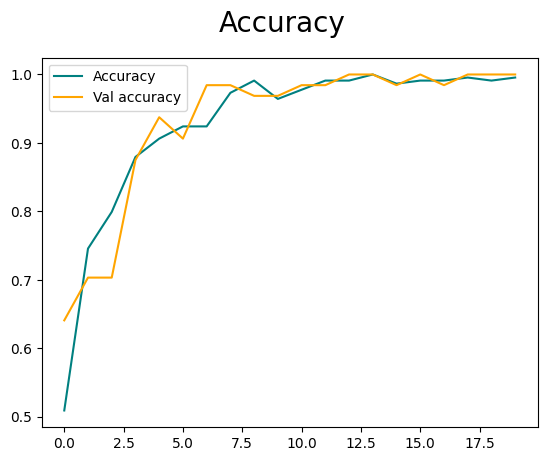

In [33]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='Accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='Val accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

# 4. Evaluate performance

### 4.1 Evaluate

In [34]:
from tensorflow.keras.metrics import Recall, Precision, BinaryAccuracy 

In [35]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [36]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 249ms/step


In [37]:
print(f'Precision: {pre.result().numpy()}\nRecall: {re.result().numpy()}\nAccuracy: {acc.result().numpy()}')

Precision: 1.0
Recall: 1.0
Accuracy: 1.0


### 4.2 Test

In [46]:
def single_image_testing(img_path, t_model):
    img = cv2.imread(img_path)
    resize_img = tf.image.resize(img, (256, 256))
    yhat = t_model.predict(np.expand_dims(resize_img/255, 0))
    if yhat > 0.5:
        return f'This is a SAD image :( - ({yhat})'
    else:
        return f'This is a HAPPY image :) - ({yhat})'

In [48]:
single_image_testing('../test_sad.jpg', model)

1/1 [==============================] - 0s 29ms/step


'This is a SAD image :( - ([[0.9970975]])'

In [47]:
single_image_testing('../test_happy.jpg', model)

1/1 [==============================] - 0s 44ms/step


'This is a HAPPY image :) - ([[0.19970901]])'

# 5. Save model

### 5.1 Save the model

In [41]:
from tensorflow.keras.models import load_model

In [42]:
model.save(os.path.join('../models', 'imageClassifierNewVersion.keras')) # saving as .h5 is for tensorflow 1.X

In [43]:
new_model = load_model(os.path.join('../models', 'imageClassifierNewVersion.keras'))

In [49]:
single_image_testing('../test_happy.jpg', new_model)

1/1 [==============================] - 0s 104ms/step


'This is a HAPPY image :) - ([[0.19970901]])'